In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet
import csv

# Read the data from the CSV file
data = pd.read_csv("Data.csv")

# Define the dimensions of the 3D matrix
num_sex = 2
num_age_category = 3
num_education_level = 4

# Calculate the joint probability distribution
joint_prob_table = pd.crosstab(index=[data['Sex'], data['Age_category'], data['Highest_education_level']],
                               columns='count',
                               normalize=False)

# Display the joint distribution matrix
print("Joint Distribution Matrix:")
print(joint_prob_table)

Joint Distribution Matrix:
col_0                                     count
Sex Age_category Highest_education_level       
1   1            0                           13
                 1                            7
                 2                           11
                 3                            6
    2            0                            1
                 1                            2
                 2                           40
                 3                           16
    3            0                            1
                 2                            6
2   1            0                            6
                 1                           11
                 2                           13
                 3                            4
    2            0                            9
                 1                            6
                 2                           26
                 3                           18
    3        

In [ ]:
def update_values(joint_prob_table):
    # Calculate sex probabilities
    Age_probabilities = joint_prob_table.groupby('Age_category').sum().fillna(0).values.flatten()

    # Calculate age_sex probabilities
    age_sex_probabilities = joint_prob_table.groupby(['Sex', 'Age_category']).sum().unstack().fillna(0).values.tolist()

    # Calculate age_education probabilities
    age_education_probabilities = joint_prob_table.groupby(['Age_category', 'Highest_education_level']).sum().unstack().fillna(0).values.tolist()

    # Calculate age_education probabilities
    sex_education_probabilities = joint_prob_table.groupby(['Highest_education_level','Sex']).sum().unstack().fillna(0).values.tolist()
    # Convert to NumPy arrays
    Age_probabilities = np.array(Age_probabilities)
    age_sex_probabilities = np.array(age_sex_probabilities)
    age_education_probabilities = np.array(age_education_probabilities)
    sex_education_probabilities = np.array(sex_education_probabilities)

    # Replace NaN values with 0 in probabilities
    Age_probabilities[np.isnan(Age_probabilities)] = 0
    age_sex_probabilities[np.isnan(age_sex_probabilities)] = 0
    age_education_probabilities[np.isnan(age_education_probabilities)] = 0
    sex_education_probabilities[np.isnan(sex_education_probabilities)] = 0

    return Age_probabilities, age_sex_probabilities, age_education_probabilities,sex_education_probabilities

def update_transition_matrix(Edu_count, joint_count_age_sex, joint_count_age_education,joint_count_sex_education):
    # Increase the parameter corresponding to male
    alpha_adjusted = [Edu_count[0], Edu_count[1], Edu_count[2]]
    transition_probs_start_adjusted = dirichlet.rvs(alpha_adjusted, size=1)[0]

    # Initialize transition probability matrix
    transition_matrix = np.zeros((len(states), len(states)))

    # Update transition probabilities from Start state to Male and Female
    # transition_matrix[0, 3:6] = transition_probs_start_adjusted
    transition_matrix[0, 3:6] = alpha_adjusted/np.sum(Edu_count)

    # Update transition probabilities from Age to Sex
    for i in range(1, num_sex + 1):
        transition_matrix[i, 3:6] = joint_count_age_sex[i - 1] / np.sum(joint_count_age_sex[i - 1])

    # Update transition probabilities from Age to Education
    for i in range(3, 6):
        transition_matrix[i, 6:10] = joint_count_age_education[i - 3] / np.sum(joint_count_age_education[i - 3])

    # Update transition probabilities from Age to Education
    for i in range(6, 10):
        transition_matrix[i, 1:3] = joint_count_sex_education[i - 6] / np.sum(joint_count_sex_education[i - 6])

    return transition_matrix



# Define function to perform Markov chain simulation
def simulate_markov_chain(transition_matrix, initial_state, num_steps):
    current_state = initial_state
    states_visited = [current_state]

    for _ in range(num_steps):
        # Choose the next state based on transition probabilities
        next_state = np.random.choice(states, p=transition_matrix[states.index(current_state)])
        states_visited.append(next_state)
        current_state = next_state

    return states_visited

In [ ]:
# Define the states
states = ['Start', 'Male', 'Female', 'Age1', 'Age2', 'Age3', 'Edu0', 'Edu1', 'Edu2', 'Edu3']

states_dict = {'Start': 0, 'Male': 1, 'Female': 2, 'Age1':1, 'Age2':2, 'Age3':3, 'Edu0':0, 'Edu1':1, 'Edu2':2, 'Edu3':3}

# Define the filename for the CSV file
filename = 'synthetic_population.csv'

# Define the column names
columns = ['Sex', 'Age_category', 'Highest_education_level']

# Write column names to the CSV file
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row with column names
    writer.writerow(columns)

Age_count,joint_count_age_sex,joint_count_age_education,joint_count_sex_education=update_values(joint_prob_table)
# print(joint_count_sex_education)

transition_matrix=update_transition_matrix(Age_count,joint_count_age_sex,joint_count_age_education,joint_count_sex_education)

data=[]

# Set initial state
initial_state = 'Start'

# Set number of steps for the simulation
num_steps = 300000

# Perform Markov chain simulation
simulation_result = simulate_markov_chain(transition_matrix, initial_state, num_steps)

thin=2
for i in range(1,300001,3):
  Sex = states_dict[simulation_result[i+2]]
  Age = states_dict[simulation_result[i]]
  Edu = states_dict[simulation_result[i+1]]
  if thin%2==0:
    data.append([Sex,Age,Edu])
  thin+=1

# joint_prob_table.loc[(Sex,Age,Edu)].values[0]+=1
# Append new data to the CSV file
with open(filename, 'a', newline='') as csvfile:
  writer = csv.writer(csvfile)

  # Write the new data rows
  writer.writerows(data)


In [ ]:
import pandas as pd

# Read the synthetic population dataset
synthetic_population = pd.read_csv("./synthetic_population.csv")

# Calculate frequency of each category for Sex
sex_frequency = synthetic_population['Sex'].value_counts().sort_index()

# Calculate frequency of each category for Age_category
age_category_frequency = synthetic_population['Age_category'].value_counts().sort_index()

# Calculate frequency of each category for Highest_education_level
education_level_frequency = synthetic_population['Highest_education_level'].value_counts().sort_index()


# Create a list of tuples for the MultiIndex
index = pd.MultiIndex.from_tuples([
    ('Sex', 'Male'),
    ('Sex', 'Female'),
    ('Age_group', 'Below 22 years'),
    ('Age_group', '22-60 years'),
    ('Age_group', 'Above 60 years'),
    ('Highest_education_level', 'No formal education'),
    ('Highest_education_level', 'Primary education'),
    ('Highest_education_level', 'Secondary education'),
    ('Highest_education_level', 'Graduation and above')
], names=['Variable', 'Description'])

# Data
data = {
    'Frequency': [
        sex_frequency.iloc[0],
        sex_frequency.iloc[1],
        age_category_frequency.iloc[0],
        age_category_frequency.iloc[1],
        age_category_frequency.iloc[2],
        education_level_frequency.iloc[0],
        education_level_frequency.iloc[1],
        education_level_frequency.iloc[2],
        education_level_frequency.iloc[3]
    ]
}

# Create DataFrame
df = pd.DataFrame(data, index=index)
print(df)


                                              Frequency
Variable                Description                    
Sex                     Male                      25740
                        Female                    24260
Age_group               Below 22 years            17609
                        22-60 years               29502
                        Above 60 years             2889
Highest_education_level No formal education        8039
                        Primary education          6407
                        Secondary education       24471
                        Graduation and above      11083


In [ ]:
# Create a list of tuples for the MultiIndex
index = pd.MultiIndex.from_tuples([('Sex', 'Male'), ('Sex', 'Female'), ('Age_group', 'Below 22 years'), ('Age_group', '22-60 years'), ('Age_group', 'Above 60 years'), ('Highest_education_level', 'No_formal education'), ('Highest_education_level', 'Primary education'), ('Highest_education_level', 'Secondary education'), ('Highest_education_level', 'Graduation and above')], names=['Variable', 'Description'])

# Sample Answer that we should obtain
sampledata = {
    'Frequency': [25324, 24676, 17955, 29642, 2403, 7490, 5655, 24400, 12455]
}

# Create DataFrame
df = pd.DataFrame(sampledata, index=index)
df


Frequency
Variable                Description                    
Sex                     Male                      25324
                        Female                    24676
Age_group               Below 22 years            17955
                        22-60 years               29642
                        Above 60 years             2403
Highest_education_level No_formal education        7490
                        Primary education          5655
                        Secondary education       24400
                        Graduation and above      12455

from matplotlib import pyplot as plt
df['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
percentage_errors=[]
for original, experimental in zip(sampledata['Frequency'], data['Frequency']):
    error = abs((experimental - original) / original) * 100
    percentage_errors.append(error)

print("Percentage Errors:", percentage_errors)


Percentage Errors: [1.642710472279261, 1.6858485978278488, 1.927039821776664, 0.4723028135753323, 20.224719101123593, 7.329773030707611, 13.297966401414676, 0.29098360655737704, 11.015656362906464]


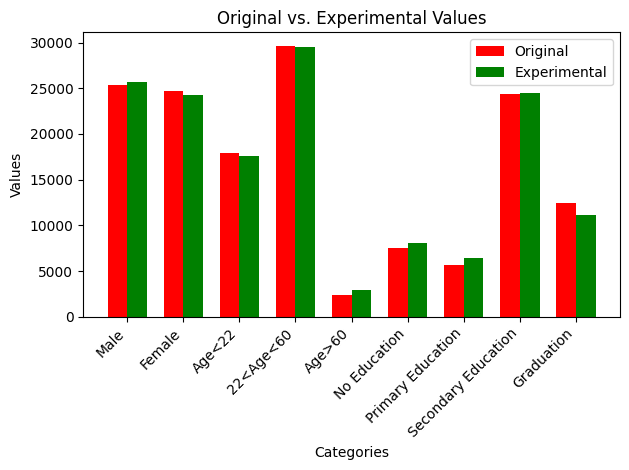

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Creating an array of indices for the bars
indices = np.arange(len(data['Frequency']))
categories = ['Male', 'Female', 'Age<22', '22<Age<60', 'Age>60', 'No Education', 'Primary Education', 'Secondary Education', 'Graduation']
# Width of each bar
bar_width = 0.35

# Plotting the original values
plt.bar(indices, sampledata['Frequency'], bar_width, label='Original', color='Red')

# Plotting the experimental values
plt.bar(indices + bar_width, data['Frequency'], bar_width, label='Experimental', color='Green')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Original vs. Experimental Values')
plt.xticks(indices + bar_width / 2, categories, rotation=45, ha='right')
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.tight_layout()
plt.show()
